In [391]:
%reset -f

In [392]:
import numpy as np 
import glob
import torch.utils.data
import scipy.stats as stats

import scipy.signal as signal

from scipy.fftpack import fft
import os
import math
import pandas as pd
from skimage import io, transform
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision as vision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm
import random
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import mean_absolute_error
import torch.nn.functional as F
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [393]:
import os
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim

# Define a custom dataset
class RadarDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.targets = []

        for folder_name in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder_name)
            radar_folder = folder_path #os.path.join(folder_path, "radar_data")  # Subfolder with radar data
            target_file = os.path.join(folder_path, 'BR_GT', f"HR_GT_{folder_name}.csv")  # Ground truth file

            if not os.path.exists(radar_folder) or not os.path.exists(target_file):
                continue

            # Load ground truth respiration rates
            targets = pd.read_csv(target_file, header=None).values.flatten()

            # Load radar data instances
            for i in range(len(targets)):
                radar_file = os.path.join(radar_folder, f"{folder_name}_{i+1}.csv")
                if not os.path.exists(radar_file):
                    continue
                radar_data = pd.read_csv(radar_file, header=None).values
                radar_data = radar_data[:, 50:150]
                radar_data = radar_data/radar_data.max() 
                self.data.append(radar_data)
                self.targets.append(targets[i])

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, target

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomHorizontalFlip()
])


train_data_dir = '/home/bhanuiit/Documents/Farhan Anti Sensing Project/Perturbation/Human Vital Sign Data (Sleep Lab)/Train'
test_data_dir = '/home/bhanuiit/Documents/Farhan Anti Sensing Project/Perturbation/Human Vital Sign Data (Sleep Lab)/Test'

train_dataset = RadarDataset(train_data_dir, transform=transform)
test_dataset = RadarDataset(test_data_dir, transform=transform)


# Function to create a DataLoader that repeats the single channel data three times to match the expected input shape
def create_dataloader(dataset, shuffle, batch_size):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=lambda x: (
        torch.stack([torch.cat([torch.Tensor(sample)] * 3, dim=0) for sample, target in x]),
        torch.tensor([target for sample, target in x])
    ))
    return loader

train_loader = create_dataloader(train_dataset, shuffle = True, batch_size=8)
test_loader = create_dataloader(test_dataset, shuffle = False, batch_size=4)

In [394]:
def sum_alligned(temporal, Fs):
    
    rms_energy = torch.sqrt(torch.mean(temporal ** 2, dim=1))
    index_max = torch.argmax(rms_energy)
    
    x_alligned = torch.zeros_like(temporal)
    
    for i in range(temporal.shape[0]):
        c = F.conv1d(temporal[i:i+1].unsqueeze(0), temporal[index_max:index_max+1].unsqueeze(0))
        lag = torch.argmax(c) - (c.size(2) // 2)
        x_old = temporal[i, :]
        
        x = torch.zeros_like(x_old)
        if lag > 0:
            x[lag:] = x_old[:-lag]
        elif lag < 0:
            x[:lag] = x_old[-lag:]
        else:
            x = x_old
            
        x_alligned[i, :] = x
    
    return torch.sum(x_alligned, dim=0)

In [395]:
Fs=47 # As Yale sleep lab radar has a sampling rate of ~47 scans per second

torch.Size([4, 3, 1411, 100])
tensor(74.0830)


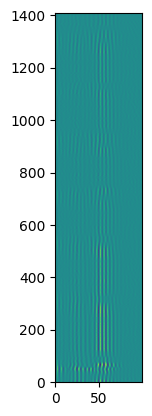

torch.Size([1411])


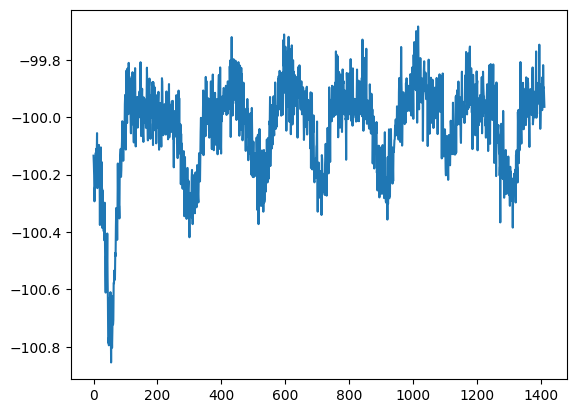

In [396]:
# Plot a sample radargram and the corresponding vital sign signal
for inputs, targets in test_loader:
    inputs = inputs.float()
    targets = targets.float()
    print(inputs.shape)
    print(targets[0])
    plt.imshow(inputs[0][0], origin='lower', aspect = 0.3)
    plt.show()# plt.gca().set_aspect('equal', adjustable='box')
    x = sum_alligned(inputs[0][0].t(), Fs)
    print(x.shape)
    plt.plot(x)
    plt.show()

    # Hide axis
    # plt.axis('off')
    break
 

In [398]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y

In [399]:
Fs = 47 # As yale sleep lab radar has a sampling rate of ~47 scans per second
fc1_br, fc2_br = 12 / 60, 25 / 60  # Breathing filter cutoff frequencies (in Hz)
fc1_hr, fc2_hr = 60 / 60, 120 / 60  # Heart rate filter cutoff frequencies (in Hz)

# Assume BR is your input signal, which is the aligned data
BR = x  # Replace 'x' with your aligned signal

# Separate heart rate signal from breathing signal using a Butterworth bandpass filter
BRF_br = butter_filter(BR.numpy(), fc1_br, fc2_br, Fs, order=4)
BRF_hr = BR.numpy() - BRF_br  # Subtract breathing signal from overall signal

# Apply heart rate filter to isolate the heart rate component
BRF_butter = butter_filter(BRF_hr, fc1_hr, fc2_hr, Fs, order=4)

# Compute FFT to find the dominant frequency component
L = len(BRF_butter)  # Length of the signal
print(f'Signal length: {L}')

Y = fft(BRF_butter)
P2 = np.abs(Y / L)  # Two-sided spectrum
P1 = P2[:L//2+1]  # One-sided spectrum
P1[1:-1] = 2 * P1[1:-1]

# Frequency range for the FFT
f = Fs * np.arange(L // 2 + 1) / L

# Find peaks in the FFT spectrum
pks, _ = signal.find_peaks(P1)

# Define the range for heart rate in Hz (60 bpm to 100 bpm)
lower_bound = 60 / 60  # 60 bpm in Hz
upper_bound = 80 / 60  # 100 bpm in Hz

# Filter peaks within the 60 to 100 bpm range
valid_peaks = [pk for pk in pks if lower_bound <= f[pk] <= upper_bound]

# Calculate the heart rate in Hz at the highest peak in this range, then convert to bpm
if len(valid_peaks) > 0:
    peak_freq = f[valid_peaks].max()  # Find the frequency of the highest peak in the valid range
    HR_bpm = peak_freq * 60  # Convert to beats per minute (bpm)
    print(f'Heart Rate: {HR_bpm} bpm')
else:
    print('No peaks found within the 60-100 bpm range.')


Signal length: 1411
Heart Rate: 69.950389794472 bpm


In [401]:
def bland_altman_plot(data1, data2):
    mean = np.mean([data1, data2], axis=0)  # Mean of both predictions and targets
    diff = data1 - data2                    # Difference between predictions and targets
    mean_diff = np.mean(diff)               # Mean difference
    std_diff = np.std(diff)                 # Standard deviation of the differences

    # Create Bland-Altman plot
    plt.figure(figsize=(8, 6))
    plt.scatter(mean, diff, color='blue', alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Difference: {mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='Upper 95% limit')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='Lower 95% limit')
    plt.title('Bland-Altman Plot')
    plt.xlabel('Mean of Predictions and Targets')
    plt.ylabel('Difference between Predictions and Targets')
    plt.legend()
    plt.grid(True)
    plt.show()

In [450]:
def bland_altman_plot(data1, data2):
    mean = np.mean([data1, data2], axis=0)  # Mean of both predictions and targets
    diff = data1 - data2                    # Difference between predictions and targets
    mean_diff = np.mean(diff)               # Mean difference
    std_diff = np.std(diff)                 # Standard deviation of the differences

    # Create Bland-Altman plot
    plt.figure(figsize=(8, 6))
    plt.scatter(mean, diff, color='blue', alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean Difference: {mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', linewidth=2, label='Upper 95% limit')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', linewidth=2, label='Lower 95% limit')
    
    # Set title and labels with font size 20pt
    # plt.title('Bland-Altman Plot', fontsize=20)
    plt.xlabel('Mean of Predictions and Targets', fontsize=20)
    plt.ylabel('Difference', fontsize=20)
    
    # Set tick parameters
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Set legend and grid
    plt.legend(fontsize=16)
    plt.grid(True)
    
    # Show plot
    plt.show()

/home/bhanuiit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bhanuiit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3316.3869
Epoch 2/10, Loss: 1640.2254
Epoch 3/10, Loss: 528.9359
Epoch 4/10, Loss: 84.8056
Epoch 5/10, Loss: 18.0003
Epoch 6/10, Loss: 13.5694
Epoch 7/10, Loss: 16.2504
Epoch 8/10, Loss: 10.5768
Epoch 9/10, Loss: 12.9483
Epoch 10/10, Loss: 13.7834
Test Loss (MSE): 13.5605
Test MAE: 2.6976
Pearson Correlation Coefficient: 0.3628


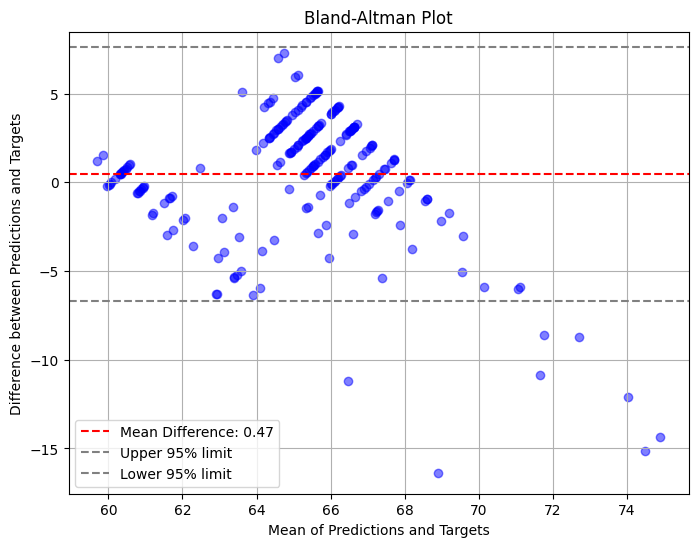


Predictions vs Ground Truths:
Predicted: 68.06, Ground Truth: 74.08
Predicted: 67.84, Ground Truth: 67.08
Predicted: 68.15, Ground Truth: 69.08
Predicted: 68.04, Ground Truth: 68.08
Predicted: 68.20, Ground Truth: 68.08
Predicted: 67.30, Ground Truth: 64.08
Predicted: 66.60, Ground Truth: 65.08
Predicted: 66.33, Ground Truth: 62.09
Predicted: 67.97, Ground Truth: 65.08
Predicted: 66.10, Ground Truth: 66.08
Predicted: 64.70, Ground Truth: 66.08
Predicted: 67.17, Ground Truth: 63.08
Predicted: 66.06, Ground Truth: 63.08
Predicted: 66.32, Ground Truth: 66.08
Predicted: 66.51, Ground Truth: 68.08
Predicted: 67.92, Ground Truth: 64.08
Predicted: 67.75, Ground Truth: 65.08
Predicted: 67.93, Ground Truth: 64.08
Predicted: 66.97, Ground Truth: 65.08
Predicted: 67.03, Ground Truth: 66.08
Predicted: 67.52, Ground Truth: 67.08
Predicted: 65.70, Ground Truth: 64.08
Predicted: 68.12, Ground Truth: 63.08
Predicted: 67.97, Ground Truth: 65.08
Predicted: 67.13, Ground Truth: 64.08
Predicted: 65.15, G

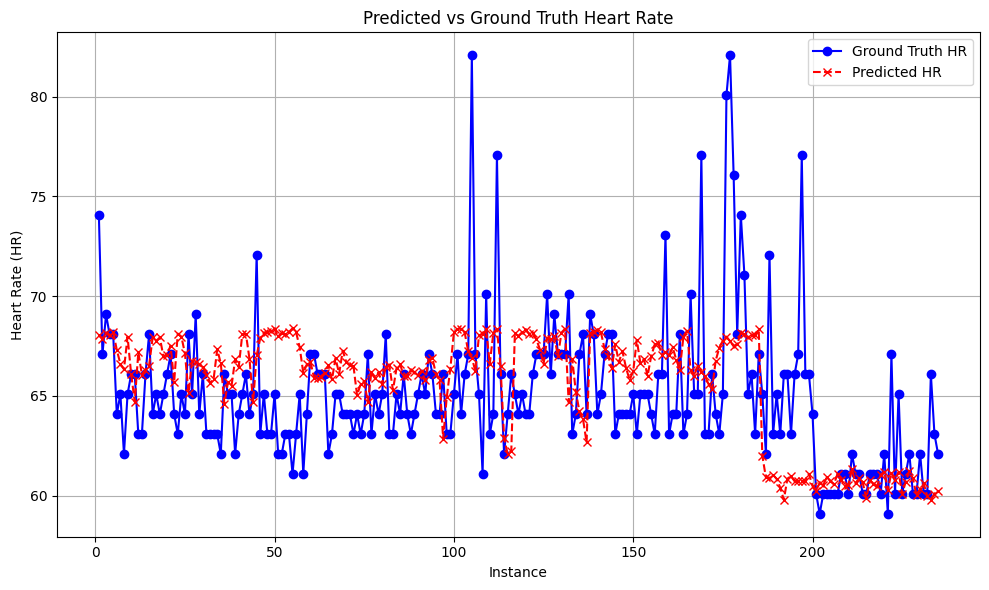

In [415]:
# Load pretrained ResNet and modify it for regression
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNetRegressor().cuda()

# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluation loop
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))

            test_loss += loss.item() * inputs.size(0)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss (MSE): {test_loss:.4f}')
    
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()
    
    mae = mean_absolute_error(all_targets, all_predictions)
    print(f'Test MAE: {mae:.4f}')

    correlation_coefficient, _ = stats.pearsonr(all_predictions, all_targets)
    print(f'Pearson Correlation Coefficient: {correlation_coefficient:.4f}')
    
    bland_altman_plot(all_predictions, all_targets)
    
    print("\nPredictions vs Ground Truths:")
    for pred, true in zip(all_predictions, all_targets):
        print(f"Predicted: {pred:.2f}, Ground Truth: {true:.2f}")
    
    # Plot predictions vs ground truths
    plt.figure(figsize=(10, 6))
    instances = np.arange(1, len(all_targets) + 1)
    plt.plot(instances, all_targets, marker='o', linestyle='-', color='blue', label='Ground Truth HR')
    plt.plot(instances, all_predictions, marker='x', linestyle='--', color='red', label='Predicted HR')
    plt.title('Predicted vs Ground Truth Heart Rate')
    plt.xlabel('Instance')
    plt.ylabel('Heart Rate (HR)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return mae
# Train and evaluate the model
train(model, train_loader, criterion, optimizer, num_epochs=10)
mae = evaluate(model, test_loader, criterion)

Test Loss (MSE): 13.7638
Test MAE: 2.7147
Pearson Correlation Coefficient: 0.3557


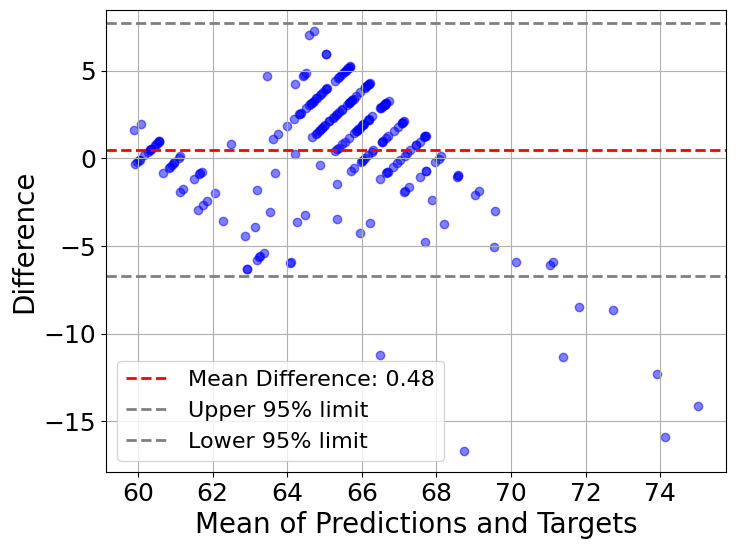


Predictions vs Ground Truths:
Predicted: 68.01, Ground Truth: 74.08
Predicted: 67.84, Ground Truth: 67.08
Predicted: 68.06, Ground Truth: 69.08
Predicted: 68.04, Ground Truth: 68.08
Predicted: 67.86, Ground Truth: 68.08
Predicted: 67.30, Ground Truth: 64.08
Predicted: 66.60, Ground Truth: 65.08
Predicted: 66.33, Ground Truth: 62.09
Predicted: 67.91, Ground Truth: 65.08
Predicted: 66.10, Ground Truth: 66.08
Predicted: 66.53, Ground Truth: 66.08
Predicted: 65.58, Ground Truth: 63.08
Predicted: 66.65, Ground Truth: 63.08
Predicted: 65.92, Ground Truth: 66.08
Predicted: 66.16, Ground Truth: 68.08
Predicted: 67.63, Ground Truth: 64.08
Predicted: 67.28, Ground Truth: 65.08
Predicted: 67.39, Ground Truth: 64.08
Predicted: 66.97, Ground Truth: 65.08
Predicted: 67.00, Ground Truth: 66.08
Predicted: 67.52, Ground Truth: 67.08
Predicted: 65.70, Ground Truth: 64.08
Predicted: 67.92, Ground Truth: 63.08
Predicted: 67.97, Ground Truth: 65.08
Predicted: 67.13, Ground Truth: 64.08
Predicted: 64.37, G

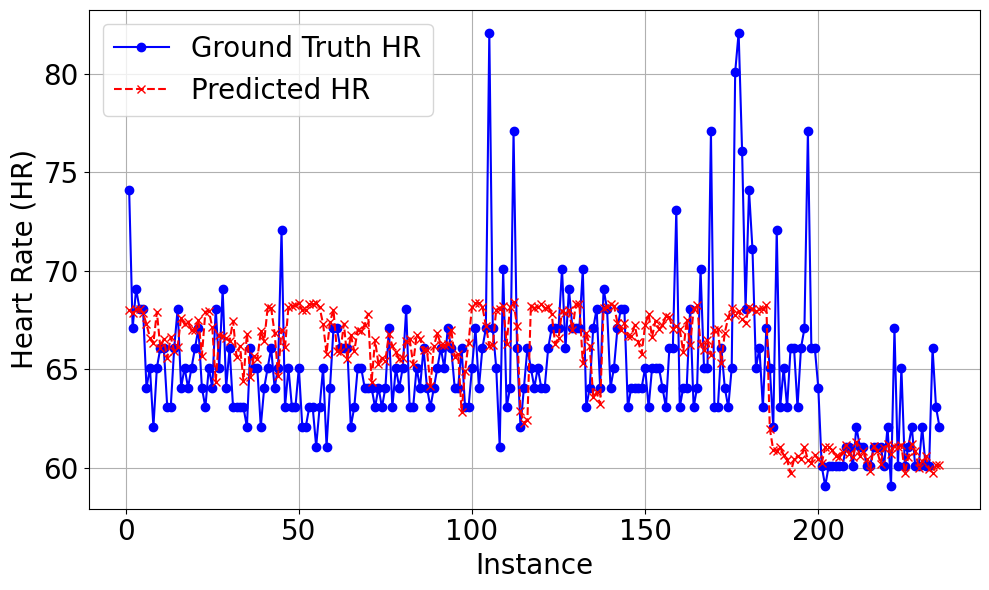

In [473]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))

            test_loss += loss.item() * inputs.size(0)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss (MSE): {test_loss:.4f}')
    
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()
    
    mae = mean_absolute_error(all_targets, all_predictions)
    print(f'Test MAE: {mae:.4f}')

    correlation_coefficient, _ = stats.pearsonr(all_predictions, all_targets)
    print(f'Pearson Correlation Coefficient: {correlation_coefficient:.4f}')
    
    bland_altman_plot(all_predictions, all_targets)
    
    print("\nPredictions vs Ground Truths:")
    for pred, true in zip(all_predictions, all_targets):
        print(f"Predicted: {pred:.2f}, Ground Truth: {true:.2f}")
    # Plot predictions vs ground truths
    plt.figure(figsize=(10, 6))
    instances = np.arange(1, len(all_targets) + 1)
    plt.plot(instances, all_targets, marker='o', linestyle='-', color='blue', label='Ground Truth HR')
    plt.plot(instances, all_predictions, marker='x', linestyle='--', color='red', label='Predicted HR')
    # plt.title('Predicted vs Ground Truth Heart Rate', fontsize=20)
    plt.xlabel('Instance', fontsize=20)
    plt.ylabel('Heart Rate (HR)', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

evaluate(model, test_loader, criterion)

In [404]:
# save the model

model_path = "HR_resnet18_Test_MAE_{:.2f}.pth".format(mae)
torch.save(model.state_dict(), model_path)


In [469]:
# PROPOSED DEFENSE Algorithm
def pgsm(model, rawscansV, target,num_iter):
    w0 = 0.4e-9  # pulse width
    f0 = 4.3e9  # center frequency of UWB radar 4.3 GHz

    # UWB Pulse generation
    Tm = 23.437e-9  # maximum time (actually fast-time) for the signal for setting #4
    Ts = 61e-12  # 61ps is the Fast-time sampling for the P440 UWB module 
    Fs = 1 / Ts  # Fast-time sampling frequency for the radar pulse
    # Fs1 = 70
    max_index11 = torch.argmax(rawscansV)

    # # Compute the column index corresponding to the max value
    # # Extract shape dimensions for interpretation
    _, _, _, num_cols = rawscansV.shape

    # # Find column index using modulo operation with the number of columns (last dimension size)
    offset_rangebin = (max_index11 % num_cols).item()


    offset = offset_rangebin * Ts  # 50th range bin is the center of oscillation
    total_rangebin = rawscansV.shape[-1] #<==============================================================
    alpha =2 # Step size
    
    
    f_est=torch.tensor(120.0,dtype=torch.float64, requires_grad=True)# initialize the weight with zero
    
    # f_est = torch.tensor(60 + (100 - 60) * torch.rand(1), dtype=torch.float64, requires_grad=True)
    
    t = torch.arange(Ts, Tm + Ts, Ts)  # Fast-time 
    x = torch.exp(-((t - offset) / w0) ** 2) * torch.exp(1j * 2 * np.pi * f0 * t)

    # UWB Pulse generation with Fast-Time converted to range bin numbers
    t1 = torch.arange(1, total_rangebin + 1)  # Range bin 1 to 384

    y = torch.exp(-((t1 - offset_rangebin) / (w0 / Ts)) ** 2) * torch.exp(1j * 2 * np.pi * f0 / Fs * t1)

    # Synthetic Radargram Generation
    num_scans = rawscansV.shape[-2]  # 635 equivalent to 9.20 seconds chosen in par with the real data recording with radar sampling freq 68 Hz
    num_rbin = total_rangebin  # 384-> Specific for setting #4

    
    amplitude = 10  # amplitude of the gaussian sinusoid #spatial expansion
    # offsets = [offset_rangebin - 10, offset_rangebin, offset_rangebin + 10, offset_rangebin - 10+50, offset_rangebin+50, offset_rangebin + 10 + 50 ]  # Initial offset
    offsets = [offset_rangebin - 30,offset_rangebin - 20,offset_rangebin - 10, offset_rangebin, offset_rangebin + 10, offset_rangebin + 20,  offset_rangebin + 30 ]  # Initial offset

    
    for t in tqdm(range(num_iter)):
        sim_rawscans = torch.zeros_like(rawscansV)
        num_periods = (f_est / 60) * num_scans / Fs1  # Radar sampling freq Fs=69 for setting
        mag = rawscansV[0][0].max().cpu()/0.2 
        for k in range(len(offsets)):
            sim_rawscans_temp = torch.zeros_like(rawscansV)
            # sim_rawscans = torch.zeros((num_scans, num_rbin), dtype=torch.cfloat)  # initialize simulated pendulum radargram
            
            
            x1 = torch.arange(1, num_scans + 1)
            y = amplitude * torch.sin(2 * np.pi * (x1 / num_scans) * num_periods) + offsets[k]
            # if k>2:
            #     mag = rawscansV[0][0].max().cpu()/2
            # Modulate the offset of the gaussian pulse according to the sinusoid
            for j in range(len(y)):
                # sim_rawscans[:,:,j, :] = mag * torch.exp(-((t1 - y[j]) / (w0 / Ts)) ** 2) * torch.exp(1j * 2 * np.pi * (f0 / Fs) * (t1 - y[j]))
                modulated_pulse = mag * torch.exp(-((t1 - y[j]) / (w0 / Ts)) ** 2) * torch.exp(1j * 2 * np.pi * (f0 / Fs) * (t1 - y[j]))
                sim_rawscans_temp[:, :, j, :] = modulated_pulse.unsqueeze(0).unsqueeze(0).expand(rawscansV.shape[0], rawscansV.shape[1], -1)

            sim_rawscans = sim_rawscans + sim_rawscans_temp
            # rawscansV = rawscansV + sim_rawscans.real#.numpy()

        # attack_signal = rawscansV

        outputs = model(rawscansV + sim_rawscans.real)
        # loss = criterion(outputs, target.view(-1, 1))
        target = torch.full_like(outputs, 120.0)
        # loss = criterion(outputs, targets.view(-1, 1))
        loss = criterion(outputs, target)

        # loss.backward()
        loss.backward(retain_graph=True)  # Retain the graph
        with torch.no_grad():  # Temporarily stop tracking history
            # f_est.data = (f_est + alpha*torch.abs(f_est.grad)).clamp(10,25)
            f_est.data = (f_est - alpha*f_est.grad).clamp(60,100)
            print(f_est)
            # plt.imshow(rawscansV[0][0], origin='lower', aspect = 0.3)
        
        f_est.grad.zero_()  # Zero out the gradients
        
    return rawscansV+sim_rawscans.real #f_est

#######

In [470]:
def evaluate_attack(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    # with torch.no_grad(): 
    for inputs, targets in test_loader:
        inputs = inputs.float().cuda()
        targets = targets.float().cuda()
        inputs1 = pgsm(model,inputs,targets,num_iter=1)
        # plt.imshow(inputs1[0][0].cpu().detach(), origin='lower', aspect = 0.1)
        # plt.show()
        outputs = model(inputs1)
        loss = criterion(outputs, targets.view(-1, 1))

        test_loss += loss.item() * inputs.size(0)
        
        all_predictions.extend(outputs.cpu().detach().numpy())
        all_targets.extend(targets.cpu().detach().numpy())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss (MSE): {test_loss:.4f}')
    
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()
    
    mae = mean_absolute_error(all_targets, all_predictions)
    print(f'Test MAE: {mae:.4f}')

    correlation_coefficient, _ = stats.pearsonr(all_predictions, all_targets)
    print(f'Pearson Correlation Coefficient: {correlation_coefficient:.4f}')
    
    bland_altman_plot(all_predictions, all_targets)
    
    print("\nPredictions vs Ground Truths:")
    for pred, true in zip(all_predictions, all_targets):
        print(f"Predicted: {pred:.2f}, Ground Truth: {true:.2f}")
    # Plot predictions vs ground truths
    plt.figure(figsize=(10, 6))
    instances = np.arange(1, len(all_targets) + 1)
    plt.plot(instances, all_targets, marker='o', linestyle='-', color='blue', label='Ground Truth HR')
    plt.plot(instances, all_predictions, marker='x', linestyle='--', color='red', label='Predicted HR')
    # plt.title('Predicted vs Ground Truth Heart Rate', fontsize=20)
    plt.xlabel('Instance', fontsize=20)
    plt.ylabel('Heart Rate (HR)', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()
    return mae

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(99.4242, dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(100., dtype=torch.float64, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(60., dtype=torch.float64, requires_grad=True)
Test Loss (MSE): 41.6637
Test MAE: 5.3534
Pearson Correlation Coefficient: 0.2141


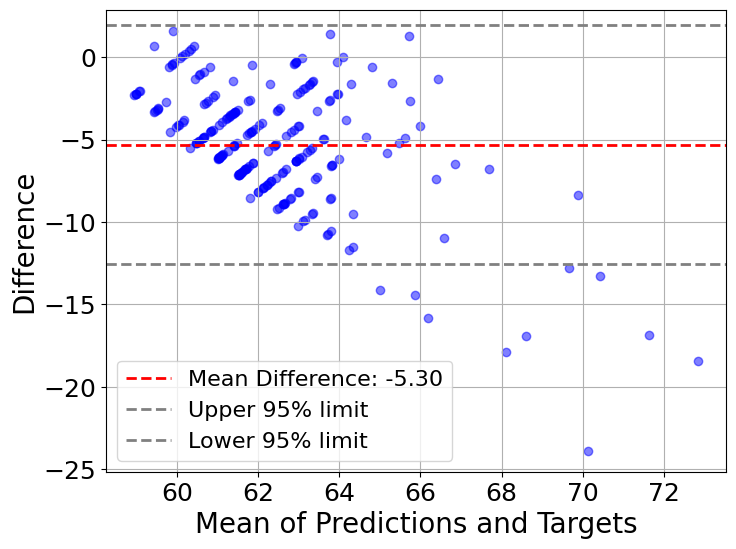


Predictions vs Ground Truths:
Predicted: 58.29, Ground Truth: 74.08
Predicted: 58.26, Ground Truth: 67.08
Predicted: 58.37, Ground Truth: 69.08
Predicted: 58.22, Ground Truth: 68.08
Predicted: 58.12, Ground Truth: 68.08
Predicted: 58.04, Ground Truth: 64.08
Predicted: 57.99, Ground Truth: 65.08
Predicted: 57.97, Ground Truth: 62.09
Predicted: 58.27, Ground Truth: 65.08
Predicted: 58.18, Ground Truth: 66.08
Predicted: 58.17, Ground Truth: 66.08
Predicted: 58.20, Ground Truth: 63.08
Predicted: 59.53, Ground Truth: 63.08
Predicted: 59.76, Ground Truth: 66.08
Predicted: 59.46, Ground Truth: 68.08
Predicted: 60.08, Ground Truth: 64.08
Predicted: 57.99, Ground Truth: 65.08
Predicted: 58.10, Ground Truth: 64.08
Predicted: 58.18, Ground Truth: 65.08
Predicted: 57.88, Ground Truth: 66.08
Predicted: 58.16, Ground Truth: 67.08
Predicted: 57.93, Ground Truth: 64.08
Predicted: 58.25, Ground Truth: 63.08
Predicted: 58.31, Ground Truth: 65.08
Predicted: 59.75, Ground Truth: 64.08
Predicted: 59.51, G

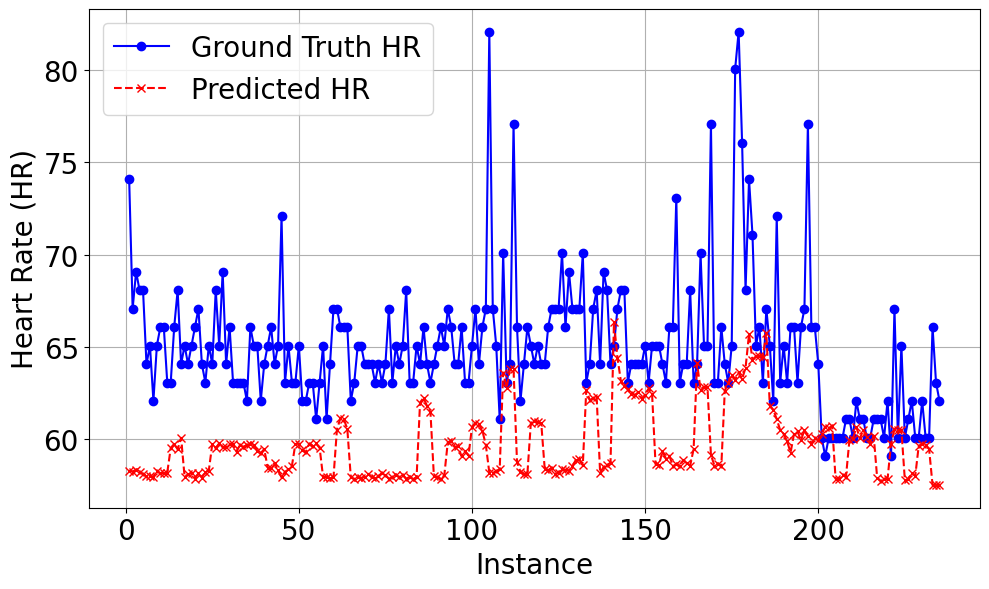

5.3534293

In [471]:
evaluate_attack(model, test_loader, criterion)